### Imports and Setup

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

from modAL.models import BayesianOptimizer, ActiveLearner, CommitteeRegressor
from modAL.acquisition import max_EI
from modAL.disagreement import max_std_sampling

from scipy import sparse

# import seqlogo

import copy

### Set random seed
seed = 5
random.seed(seed)
np.random.seed(seed)

### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

# 1.1. Data Load (5 points)
**In this question, you need to build a regression model with active learning for predicting binding affinity between MHC class I and small peptides. The dataset is provided in file `hw3_data.csv`.**

**TODO**
- **Read the data into the jupyter notebook. Columns 2 and 3 in the dataset file correspond to peptide sequences and pIC50 values.**

### Load Data

In [2]:
data = pd.read_csv('data/hw3_data.csv', delimiter=',',header=0)
print(data.shape)
data.head(5)

(9051, 4)


,id,allele,seq,pIC50
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0
1,seq1,HLA-A*02:01,AIYDTMQYV,9.0
2,seq2,HLA-A*02:01,ALATFTVNI,9.0
3,seq3,HLA-A*02:01,ALDEGLLPV,9.0
4,seq4,HLA-A*02:01,ALFPIIWAL,9.0


# 1.2. Encode Data (10 points)
**Since we are dealing with machine learning models, you need to convert peptide sequences into feature vectors. The simplest way to do this is to use a one-hot encoding.**

**Each character in the amino acid alphabet will correspond to a binary vector with a single 1 and all zeros. The size of the vector is equal to the size of the amino acid alphabet. The position of 1 encodes a specific amino acid. The resulting feature vector for a peptide is a concatenation of the feature vectors of its amino acids. Since we are dealing with 9-mers here, the size of the feature vector for a peptide should be equal to 9*(size of the amino acid alphabet).**

**TODO**
- **Encode the data.**
- **Split data into train and test datasets.**

### Encode Data
I want to keep some notion of the order of the amino acids. The 3D structure they form is vital for predicting binding quality. One possible way is to group letters in order. How do I decide how many letters constitutes a group?

Ex: 3-mers
```
AIIDYIAYM
AII
 IID
  IDY
    ...
      AYM
```

3-mers results in N < J, where N is the number of samples and J is the number of features. If we want to use multivariate regression, we'll need to use ridge regression or some other sparse form.

In [3]:
data['seq'].str.len().unique()  # every seq is length 9

array([9])

In [4]:
# create separate columns for each amino acid
for i in range(9):
    colname='seq'+str(i)
    data[colname] = [x[i] for x in data['seq']]

In [5]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [6]:
# number of unique letters
len(data['seq0'].unique())

20

In [7]:
# # create triplets
# k = 3
# count = 9-k+1
# start=0
# end=k
# for i in range(count):
#     colname='triplet'+str(i)
#     data[colname] = [x[start:end] for x in data['seq']]
#     start +=1
#     end +=1

In [8]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [9]:
X_df = data.drop(['pIC50','id','allele', 'seq'],axis=1)
y = data['pIC50']
print(X_df.shape)
print(y.shape)

(9051, 9)
(9051,)


In [10]:
X_df.head(1)

,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,A,I,I,D,Y,I,A,Y,M


In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X_df)
print(type(X_enc))
print(X_enc.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(9051, 180)


In [12]:
# convert to numpy array
X_pool=sparse.csr_matrix.toarray(X_enc)
print(type(X_pool))
print(X_pool.shape)
y_pool = y.to_numpy()
print(y_pool.shape)

<class 'numpy.ndarray'>
(9051, 180)
(9051,)


### Split Data
- X_initial: set of samples removed from data pool for initialization
- X_train: 2/3 of data pool
- X_test: 1/3 of data pool

In [13]:
#?? initial training set for active learners?
# n_initial = 10

# # select random instances to use as initial active learning training set
# idx_initial = np.random.choice(X_np.shape[0], n_initial)
# X_initial = X_np[idx_initial]
# y_initial = y_np[idx_initial]
# print(X_initial.shape)
# print(y_initial.shape)


# # remove from pool of data for testing and training
# X_pool = np.delete(X_np, idx_initial, axis=0)
# y_pool = np.delete(y_np, idx_initial, axis=0)
# print(X_pool.shape)
# print(y_pool.shape)


# split remaining pool of data
X_train, X_test, y_train, y_test = train_test_split(X_pool, y_pool, test_size=0.33)
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(6064, 180)
(6064,)
(2987, 180)
(2987,)


### Experiment with offline learners

In [14]:
%%time

# train RFC model on entire pool of data
rf = RandomForestRegressor(n_estimators = 20, 
                            max_depth = 6, 
                            random_state = seed)
rf.fit(X_train, y_train)

# calculate accuracy
print(rf.score(X_test,y_test))  # uses R^2

0.4769976135583013
CPU times: user 355 ms, sys: 5.62 ms, total: 361 ms
Wall time: 362 ms


In [15]:
%%time

clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

print(clf.score(X_test,y_test))  # uses R^2

0.6323258584401178
CPU times: user 43.9 ms, sys: 6.45 ms, total: 50.4 ms
Wall time: 22.3 ms


In [16]:
# %%time
# # 12 minutes for (5931,180)

# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# gpr = GaussianProcessRegressor(kernel,random_state=seed)
# gpr.fit(X_train, y_train)
# print(gpr.score(X_test,y_test)) #0.69 score

# 1.3. Build Active Learning  model (20 points)
**Now you can start building the model with active learning! We do not give you any specific instructions as to which algorithm to implement. You can use something similar to [this](https://modal-python.readthedocs.io/en/latest/content/examples/active_regression.html) example in modAL documentation, or query-by-committee when a label is requested for samples which the committee is least confident about or anything else covered in the lectures.**

**TODO**
- **Implement an active learning algorithm using modAL.**

In [17]:
def get_next_sample(learner, X, y):
    
    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = learner.query(X)
    
    # modify indexing to interpret as collection of one element with d features
    query_sample_reshaped = query_sample.reshape(1,-1)
   
    # obtain the query label
    query_label = y[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1,)
    
    return query_sample_reshaped, query_label_reshaped, query_idx

In [18]:
def run_active_learner(learner, X_pool, y_pool, X_test, y_test, num_queries):

    history = [] # score history
    
    # score model before active learning starts
    y_pred = learner.predict(X_test)#, return_std=False)
    history.append(r2_score(y_test,y_pred))  # y_true,y_pred

    # perform active learning
    for q in range(num_queries):

        # get sample
        X_sample, y_sample, query_idx = get_next_sample(learner, X_pool, y_pool)

        # use new sample to update the model
        learner.teach(X_sample, y_sample)

        # score against test data
        y_pred = learner.predict(X_test)#, return_std=False)
        history.append(r2_score(y_test,y_pred))
        
        # remove labeled instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
    return history

In [19]:
%%time
# 5 min for 2 learners 200 queries
#?? why rerunning messes up r2 values

# make a copy of the data for use in this section
X_pool_comm = copy.deepcopy(X_train)
y_pool_comm = copy.deepcopy(y_train)

# kernel
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# generate initialization data sets
initial_idx = []
n_initial = 10
n_learners = 2
for each in range(n_learners):
    initial_idx.append(np.random.choice(len(X_pool_comm), size=n_initial, replace=False))


# initialize the regressors in the Committee
learner_list = [ActiveLearner(
                        estimator=GaussianProcessRegressor(kernel),
                        X_training=X_pool_comm[idx],
                        y_training=y_pool_comm[idx]
                )
                for idx in initial_idx]

# initializing the Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

# active regression
n_queries = 200
history_comm = []
for q in range(n_queries):
    
    # get sample
    X_sample, y_sample, query_idx = get_next_sample(committee, X_pool_comm, y_pool_comm)
    
    # use new sample to update the model
    committee.teach(X_sample, y_sample)

    # remove labeled instance from pool
    X_pool_comm = np.delete(X_pool_comm, query_idx, axis=0)
    y_pool_comm = np.delete(y_pool_comm, query_idx)
    
    # score the current model   
    y_pred = committee.predict(X_test, return_std=False)
    r2=r2_score(y_test,y_pred)
    history_comm.append(r2)

CPU times: user 7min 1s, sys: 4.99 s, total: 7min 6s
Wall time: 1min 48s


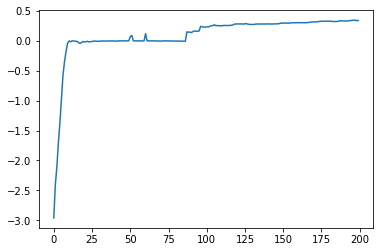

In [20]:
plt.plot(history_comm)

# 1.4. Score model (5 points)
**The quality of the model should be measured on the test set as $R^2$ score. The minimum acceptable $R^2$ score is 0.6.**

**TODO**
- **Score the model on the test set using $R^2$.**

In [21]:
# score the final model
y_pred_comm = committee.predict(X_test, return_std=False)
r2=r2_score(y_test,y_pred_comm)
print("R2 for test set",r2)

# compare against R2 of the remaining pool
y_pred_comm_pool = committee.predict(X_pool_comm)
r2_pool = r2_score(y_pool_comm, y_pred_comm_pool)
print("R2 for pool",r2_pool)

R2 for test set 0.33998170330135113
R2 for pool 0.3245019675582951


# 1.5. Compare with Random Active Learner (5 points)
**TODO**
- **Compare your results with no active learning scheme by training a random forest classifier on the same amount of data points, but selected randomly.**

In [23]:
def random_query(learner, X):
   
    n_samples = len(X)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X[query_idx]

In [27]:
# online learner with random query

# copy data for this section
X_pool_rand = copy.deepcopy(X_train)
y_pool_rand = copy.deepcopy(y_train)



# use the same initialization to make comparison meaningful
initial_rand = initial_idx[0]

regressor = ActiveLearner(
    estimator=RandomForestRegressor(n_estimators = 20, max_depth = 6, random_state = seed),
    query_strategy=random_query,
    X_training=X_pool_rand[initial_rand], 
    y_training=y_pool_rand[initial_rand]
)


history_rand = []
for q in range(n_queries):
    
    # get sample
    X_sample, y_sample, query_idx = get_next_sample(regressor, X_pool_rand, y_pool_rand)
    
    # use new sample to update the model
    regressor.teach(X_sample, y_sample)

    # remove labeled instance from pool
    X_pool_rand = np.delete(X_pool_rand, query_idx, axis=0)
    y_pool_rand = np.delete(y_pool_rand, query_idx)
    
    # score the current model
    y_pred = regressor.predict(X_test)
    r2=r2_score(y_test,y_pred)
    history_rand.append(r2)

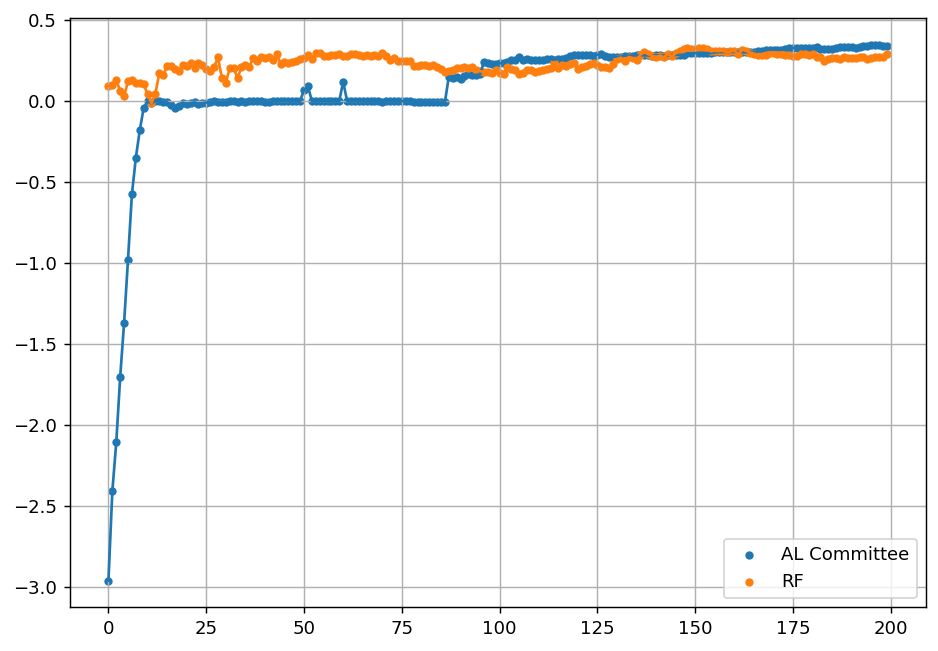

In [28]:
# compare the two results
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_comm)
ax.scatter(range(len(history_comm)), history_comm, s=13, label = 'AL Committee')

ax.plot(history_rand)
ax.scatter(range(len(history_rand)), history_rand, s=13, label = 'RF')

ax.grid(True)

# ax.set_title('Incremental classification accuracy')
# ax.set_xlabel('Query iteration')
# ax.set_ylabel('Classification Accuracy')

ax.legend()
plt.show()

In [29]:
#?? why compare test and pool (with missing entries)
# score the final model
y_pred_rand = regressor.predict(X_test)
r2=r2_score(y_test,y_pred_rand)
print("R2 for test set",r2)

# compare against R2 of the remaining pool
y_pred_rand_pool = committee.predict(X_pool_rand)
r2_pool = r2_score(y_pool_rand, y_pred_rand_pool)
print("R2 for pool",r2_pool)

R2 for test set 0.29069494697505205
R2 for pool 0.33649504759414417


# 1.6. Summary (5 points)
**TODO**
- **Write a paragraph about your method, describe your observations and difficulties.**

### Method
- Consider encoding sequence k-mers together because order of sequence is important too. This controls protein shape, which should strongly affect binding. Worried about N < J.
- Tried various regressors: Ridge, Random Forest, Gaussian Process. GP did the best on the entire training set, with Ridge being a close second.


### Difficulties
- understanding kernel in Gaussian process (which to use)
- understanding what to modify to improve R2 values. Is it the encoding? Is it the number of committee members? Is it the query strategy? Is it the hyperparmeters or kernel for the regressor?
- Rerunning cells messes up R2 value. Goes from 0.3 to -0.01.

### Observations
- AL is better than random